# S2S Skill

What was the forecast skill of S2S models? 
Did grid-cell or spatial bias correction schemes improve results?

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import paraguayfloodspy.visualize as viz # custom plotting library
from paraguayfloodspy.pars import GetPars

Define parameters

In [2]:
%matplotlib inline
savefigs = True

In [3]:
forecasts = ['Raw', 'XLR', 'PCR', 'CCA']

In [4]:
obs_url = 'http://iridl.ldeo.columbia.edu/home/.agmunoz/.Paraguay/.Obs/.Obsrain_90thpctl/dods'
obs_exceed = xr.open_dataarray(obs_url)
obs_exceed = obs_exceed.isel(T=(obs_exceed['T'].size - 1))
hatch0 = np.ma.masked_invalid(obs_exceed.values)
hatch = np.ma.masked_less(hatch0, 0.9)
Xh, Yh = np.meshgrid(obs_exceed.X, obs_exceed.Y)

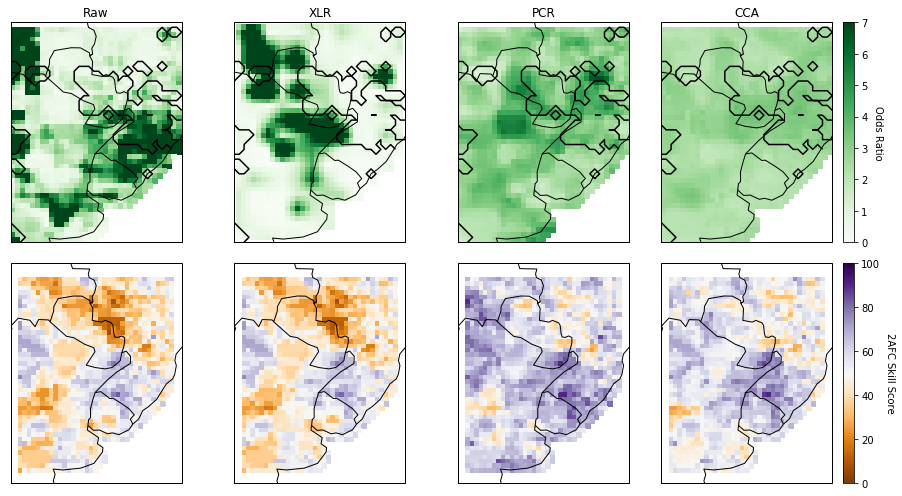

In [5]:
ncols = len(forecasts)
fig, axes = viz.SetupAxes(ncol = ncols, nax = 2*len(forecasts), proj = ccrs.PlateCarree(), figsize = [13, 7])
for i,m in enumerate(forecasts):
    # First plot the forecast for December 1-7 2015
    ax = axes[0, i]
    url = 'http://iridl.ldeo.columbia.edu/ds%3A/home/.agmunoz/.Paraguay/.{}/.Odds_1-7Dec2015/dods'.format(m)
    ds = xr.open_dataarray(url)
    X,Y = np.meshgrid(ds.X, ds.Y)
    sub = ds.values
    sub = np.ma.masked_invalid(sub)
    sub = np.ma.masked_less(sub, 0)
    if len(sub.shape) == 3:
        sub = sub[0,:,:]
    C1 = ax.pcolormesh(X, Y, sub, cmap="Greens", transform=ccrs.PlateCarree(), vmin=0, vmax=7)
    ax.contour(Xh, Yh, hatch0, levels = [-100, 0, 100], colors='black', size=1.5)
    ax.set_title(m)
    if i == (ncols - 1):
        cbar1 = fig.colorbar(C1, ax = ax)
        cbar1.set_label('Odds Ratio', rotation=270)
        cbar1.ax.get_yaxis().labelpad = 15
    # Next plot the 2AFC Skill Score
    ax = axes[1, i]
    url = 'http://iridl.ldeo.columbia.edu/home/.agmunoz/.Paraguay/.{}/.2AFCProbFcsts/dods'.format(m)
    ds = xr.open_dataarray(url)
    X,Y = np.meshgrid(ds.X, ds.Y)
    sub = ds.values
    sub = np.ma.masked_invalid(sub)
    sub = np.ma.masked_greater(sub, 100)
    sub = np.ma.masked_less(sub, 0)
    if len(sub.shape) == 3:
        sub = sub[0,:,:]
    C2 = ax.pcolormesh(X, Y, sub, cmap="PuOr", transform=ccrs.PlateCarree(), vmin=0, vmax=100)
    if i == (ncols - 1):
        cbar2 = fig.colorbar(C2, ax = ax)
        cbar2.set_label('2AFC Skill Score', rotation=270)
        cbar2.ax.get_yaxis().labelpad = 15
viz.FormatAxes(axes, coast=True, grid=False, border=True, river = False, feature_list = [], 
               states=False, extent = None, ticks=None)
if savefigs:
    fig.savefig("../_figs/ForecastSkill.pdf", bbox_inches="tight")

In [6]:
area_avg = xr.open_dataset("../_data/s2s/AreaAvg.nc")
area_avg['L'] = np.int_(area_avg['L'].astype('timedelta64[D]') / np.timedelta64(1, 'D'))

In [7]:
pars = GetPars('all')

In [8]:
prcp = xr.open_dataarray("../_data/rainfall/subset/cpc_raw.nc")
prcp_rpy = prcp.sel(lon = slice(pars['rpy_rain']['lonmin'], pars['rpy_rain']['lonmax']), 
                    lat = slice(pars['rpy_rain']['latmin'], pars['rpy_rain']['latmax'])).mean(dim=['lon', 'lat'])
climatology = prcp_rpy.sel(time = np.in1d(prcp_rpy['time.month'], [11,12,1,2])).mean(dim='time')
prcp_rpy = pd.DataFrame({'prcp_rpy': prcp_rpy.to_pandas()})

In [9]:
prcp_rpy = prcp_rpy.rolling(3).mean().dropna()
prcp_rpy = prcp_rpy['2015-11-01':'2016-02-29']

In [10]:
L_plt = [5,14,19, 30]

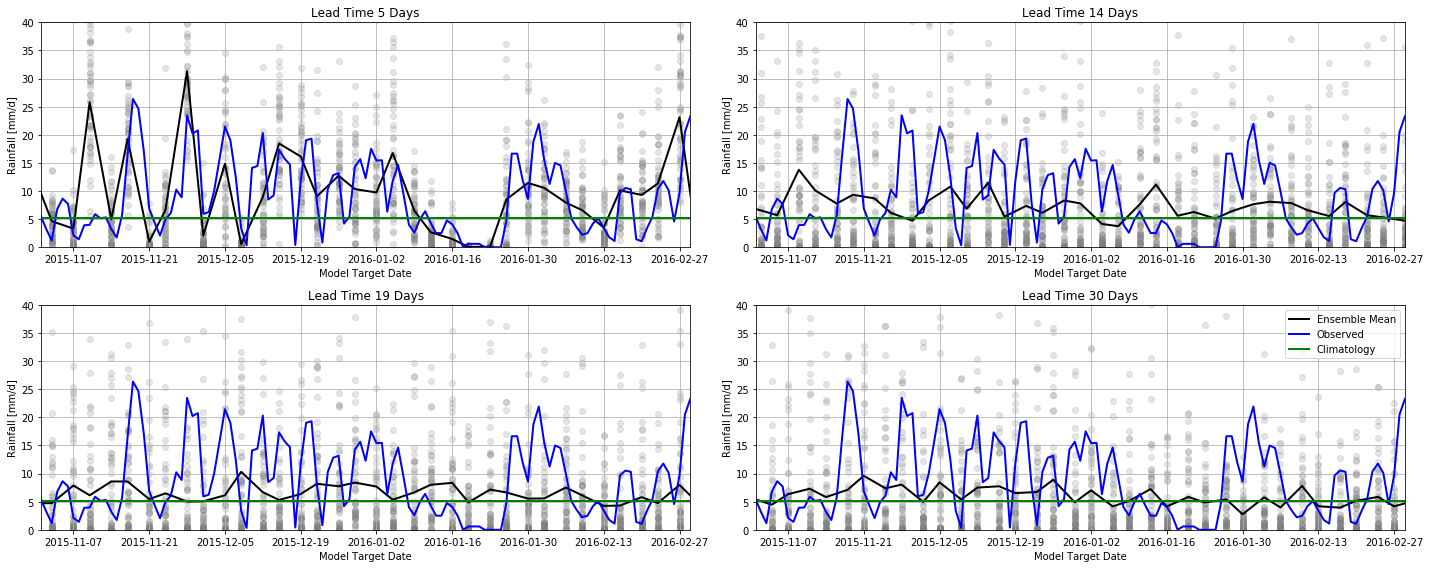

In [11]:
fig,axes=plt.subplots(figsize=(20,8), nrows=2, ncols=2)
for i,L in enumerate(L_plt):
    ax=viz.GetRowCol(i, axes)
    ensemble_mean = area_avg.sel(L=L).mean(dim='M').to_dataframe().dropna()
    ensemble_mean['target_date'] = ensemble_mean['date_target'] = ensemble_mean.index + datetime.timedelta(L)
    ax.plot(ensemble_mean['target_date'], ensemble_mean['tp'], label='Ensemble Mean', color='black', linewidth=2)
    ax.plot(prcp_rpy.index, prcp_rpy['prcp_rpy'], label='Observed', color='blue', linewidth=2)
    ax.axhline(climatology, color='green', label='Climatology', linewidth=2)
    for M in area_avg['M']:
        sub = area_avg.sel(M = M, L=L)
        sub = sub.to_dataframe().dropna()
        sub['date_target'] = sub.index + datetime.timedelta(L)
        ax.scatter(sub['date_target'].values, sub['tp'].values, 
                   color='gray', alpha=.2, marker = 'o')
    ax.set_title("Lead Time {} Days".format(L))
    ax.grid(True)
    ax.set_xlim(('2015-11-01', '2016-02-29'))
    ax.set_ylim((0, 40))
    ax.set_xlabel("Model Target Date")
    ax.set_ylabel("Rainfall [mm/d]")
    if i == (len(L_plt)-1):
        ax.legend()
plt.tight_layout()
if savefigs:
    fig.savefig("../_figs/Chiclet.pdf", bbox_inches="tight")